## The Cliff Walking Problem
This is a modification of the grid world problem. It is an undiscounted, episodic task with the start state indicated on the bottom left and the goal on the bottom right. All transitions yeild a reward of -1 except those in the cliff region which yield -100 and send the agent back to the start state. We use this to highlight the difference between learning on-policy (sarsa) and learning off-policy (q-learning).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

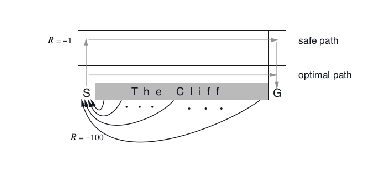

In [2]:
img = mpimg.imread('cliff walking.png')
plt.axis('off')
plt.imshow(img)

In [3]:
LEFT = 0
UP = 1
RIGHT = 2
DOWN = 3

# Coordinates in (row, column) format
INITIAL_STATE = [3, 0]
FINAL_STATE = [3, 11]

WIDTH = 12
HEIGHT = 4
ACTION_COUNT = 4

MAX_X = WIDTH - 1
MAX_Y = HEIGHT - 1

In [4]:
class CliffWalk:
    pos = []
    
    def __init__(self):        
        self.reset()
        
    
    def step(self, action):
        """
        Takes the given action and returns a tuple (next_state, reward, done)
        """
        reward = 0
        done = self.is_final()
        
        if not done:   
            # Normally, reward is -1
            reward = -1
            new_pos = np.copy(self.pos)
            
            if action == LEFT:
                new_pos[1] -= 1
            elif action == UP:
                new_pos[0] -= 1
            elif action == RIGHT:
                new_pos[1] += 1
            elif action == DOWN:
                new_pos[0] += 1                     
            
            # If final position is valid, move to new location
            if not (new_pos[0] < 0 or new_pos[0] > MAX_Y or new_pos[1] < 0 or new_pos[1] > MAX_X):
                if self.is_cliff(new_pos):
                    reward = -100
                    self.pos = np.copy(INITIAL_STATE)
                else:
                    self.pos = new_pos                
        
        return np.copy(self.pos), reward, self.is_final()
    
    def is_cliff(self, pos):
        return (pos[0] == 3) and (1 <= pos[1] <= 10)
    
    def reset(self):
        self.pos = np.copy(INITIAL_STATE)
        return np.copy(self.pos)
        
    def is_final(self):
        return self.pos[0] == FINAL_STATE[0] and self.pos[1] == FINAL_STATE[1]    

In [5]:
def epoch_greedy(Q, state):
    qa = Q[state[0], state[1]]
    prob = np.random.rand(1)
    if prob > epsilon:
        # exploit (greedy)
        action_index = np.random.choice(np.flatnonzero(qa == qa.max()))
    else:
        # explore (random action)
        action_index = np.random.randint(0, ACTION_COUNT)
    
    return action_index

In [6]:
def moving_average(a, w=10):
    if len(a) < w:
        return a[:]
    return [val if idx < w else sum(a[(idx-w):idx])/w for idx, val in enumerate(a)]

In [7]:
# Sarsa learning
gamma = 1 # no discount
epsilon = 0.1
alpha = 0.5
Q = np.zeros((HEIGHT, WIDTH, ACTION_COUNT))
episodes = 5000

env = CliffWalk()
rewards = 0
episode = 0
s = env.reset()
y_sarsa = [] # For plotting

while episode < episodes:    
    # Select action using policy derived from Q (e-greedy)
    a = epoch_greedy(Q, s)
        
    # Take action and observe next state and reward
    s_, r, done = env.step(a)
    
    # Choose A' from S' using policy derived from Q (e-greedy)
    a_ = epoch_greedy(Q, s_)
    
    # Update
    if done:
        Q[s[0], s[1], a] = Q[s[0], s[1], a] + alpha * (r - Q[s[0], s[1], a])
    else:
        Q[s[0], s[1], a] = Q[s[0], s[1], a] + alpha * (r + gamma * Q[s_[0], s_[1], a_] - Q[s[0], s[1], a])
    
    s = s_
    rewards += r
    
    # Episode over, reset environment
    if done:                
        episode += 1
        y_sarsa.append(rewards)
        
        s = env.reset()
        rewards = 0

In [8]:
# Q-learning
gamma = 1
epsilon = 0.1
alpha = 0.5
Q = np.zeros((HEIGHT, WIDTH, ACTION_COUNT))

env = CliffWalk()
rewards = 0
episode = 0
s = env.reset()
y_ql = [] # For plotting

while episode < episodes:    
    # Select action using policy derived from Q (e-greedy)
    a = epoch_greedy(Q, s)
        
    # Take action and observe next state and reward
    s_, r, done = env.step(a)
    
    # Update
    if done:
        Q[s[0], s[1], a] = Q[s[0], s[1], a] + alpha * (r - Q[s[0], s[1], a])
    else:
        max_qa = np.amax(Q[s_[0], s_[1]])
        Q[s[0], s[1], a] = Q[s[0], s[1], a] + alpha * (r + gamma * max_qa - Q[s[0], s[1], a])
    
    s = s_
    rewards += r
    
    # Episode over, reset environment
    if done:                
        episode += 1
        y_ql.append(rewards)
        
        s = env.reset()
        rewards = 0

In [11]:
sarsa_average = moving_average(y_sarsa, w=100)
ql_average = moving_average(y_ql, w=100)


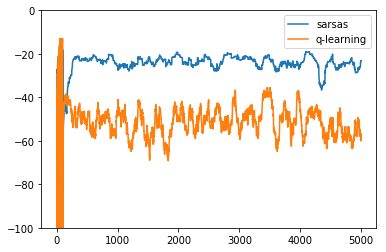

In [12]:
x = range(episodes)
plt.ylim([-100, 0])
plt.plot(x, sarsa_average, label='sarsas')
plt.plot(x, ql_average, label='q-learning')
plt.legend()
plt.show()

The graph shows the performance of both Sarsa and Q-learning with $\epsilon$-greedy action selection. Q-learning learns values for the optimal policy (travels along the edge of the cliff). However, due to the random factor in it's action selection, it occasionally falls of the cliff. Sarsa on the other hand takes this into consideration and learns the longer but safer path. In conclusion, although Q-learning learns the values of the optimal policy, its online performance is worse than that of Sarsa. However, if $\epsilon$ were gradually reduced, then both methods would asymptotically converge to the optimal policy.

## References
1. Richard S. Sutton, Andrew G. Barto (1998). Reinforcement Learning: An Introduction. MIT Press.